## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

![image.png](attachment:image.png)

In [9]:
import os
import keras
import tensorflow
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [10]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [11]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.np_utils.to_categorical(y, num_classes)
    return y    

In [12]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import precision_score, recall_score

class Record_tp_tn(Callback):
    def __init__(self, valid_data=(x_test, y_test)):
        self.validation_data = valid_data
   
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        # for i in record_items:
        #     if i not in self.params['metrics']:
        #         self.params['metrics'].append(i)
        for i in record_items:
            if i not in logs.keys():
                logs[i]=[]
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs["val_tp"] = precision_score(y_true = y_true, y_pred = y_pred, average="weighted")
        logs["val_tn"] = recall_score(y_true = y_true, y_pred = y_pred, average="weighted")

        
rec_tptn = Record_tp_tn()

In [20]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_10 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               3289

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 198ms/step - loss: 1.7513 - accuracy: 0.3888 - val_loss: 2.0181 - val_accuracy: 0.2586 - val_tp: 0.0100 - val_tn: 0.1000
Epoch 3/10
 1/49 [..............................] - ETA: 7s - loss: 1.6993 - accuracy: 0.4004

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 199ms/step - loss: 1.6241 - accuracy: 0.4314 - val_loss: 1.8456 - val_accuracy: 0.3439 - val_tp: 0.1100 - val_tn: 0.1001
Epoch 4/10
 1/49 [..............................] - ETA: 7s - loss: 1.5326 - accuracy: 0.4668

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 12s 239ms/step - loss: 1.5487 - accuracy: 0.4576 - val_loss: 1.7322 - val_accuracy: 0.3982 - val_tp: 0.1000 - val_tn: 0.1027
Epoch 5/10
 1/49 [..............................] - ETA: 7s - loss: 1.5339 - accuracy: 0.4707

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 204ms/step - loss: 1.4903 - accuracy: 0.4772 - val_loss: 1.6483 - val_accuracy: 0.4206 - val_tp: 0.0877 - val_tn: 0.1065
Epoch 6/10
 1/49 [..............................] - ETA: 8s - loss: 1.4504 - accuracy: 0.5039

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 12s 244ms/step - loss: 1.4436 - accuracy: 0.4935 - val_loss: 1.5898 - val_accuracy: 0.4407 - val_tp: 0.0887 - val_tn: 0.1149
Epoch 7/10
 1/49 [..............................] - ETA: 8s - loss: 1.3990 - accuracy: 0.4863

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 202ms/step - loss: 1.4055 - accuracy: 0.5094 - val_loss: 1.5576 - val_accuracy: 0.4502 - val_tp: 0.0867 - val_tn: 0.1209
Epoch 8/10
 1/49 [..............................] - ETA: 7s - loss: 1.3896 - accuracy: 0.5146

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 11s 229ms/step - loss: 1.3690 - accuracy: 0.5231 - val_loss: 1.5236 - val_accuracy: 0.4600 - val_tp: 0.0809 - val_tn: 0.1314
Epoch 9/10
 1/49 [..............................] - ETA: 7s - loss: 1.4005 - accuracy: 0.4932

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 212ms/step - loss: 1.3370 - accuracy: 0.5352 - val_loss: 1.5025 - val_accuracy: 0.4663 - val_tp: 0.0804 - val_tn: 0.1369
Epoch 10/10
 1/49 [..............................] - ETA: 7s - loss: 1.2888 - accuracy: 0.5430

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


49/49 [==============================] - 10s 197ms/step - loss: 1.3068 - accuracy: 0.5451 - val_loss: 1.4920 - val_accuracy: 0.4696 - val_tp: 0.0814 - val_tn: 0.1363


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


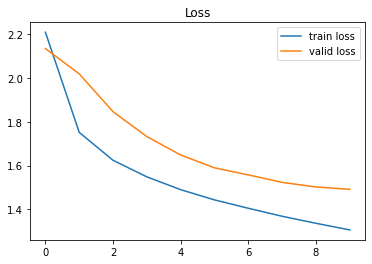

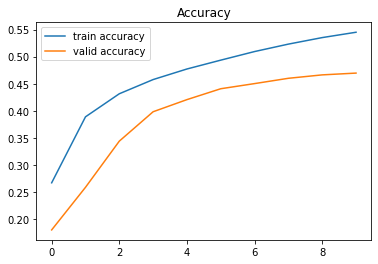

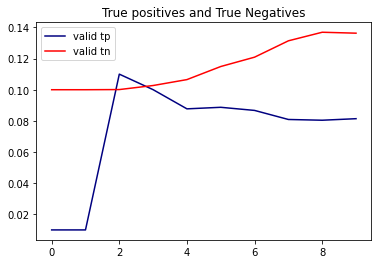

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
